In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn import metrics
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff

In [2]:
def split(values, k=20):
    assert len(values) % k == 0
    stepsize = len(values) // k
    value_list = []
    for i in range(k):
        value_list.append(values[i*stepsize:(i + 1)*stepsize])
    return np.asanyarray(value_list)

In [99]:
mask_path = '../history/AUG23_adam_1e-05_contour/result_images/all_masks.png'
contour_path = '../history/AUG23_withlen_mu1_adam_1e-05_contour/result_images/all_predictions.png'
dice_path = '../history/AUG23_adam_1e-05_dice/result_images/all_predictions.png'
bce_path = '../history/AUG23_adam_1e-05_bce/result_images/all_predictions.png'
masks = np.asarray(Image.open(mask_path))
contour_imgs = np.asanyarray(Image.open(contour_path))
dice_imgs = np.asanyarray(Image.open(dice_path))
bce_imgs = np.asanyarray(Image.open(bce_path))

In [100]:
masks = masks / 255
contour_imgs = contour_imgs / 255
dice_imgs = dice_imgs / 255
bce_imgs = bce_imgs / 255

In [101]:
masks = split(masks)
contour_imgs = split(contour_imgs)
dice_imgs = split(dice_imgs)
bce_imgs = split(bce_imgs)

In [102]:
def descrtetize(img, thres=0.5):
    return (img >= thres).astype(int)

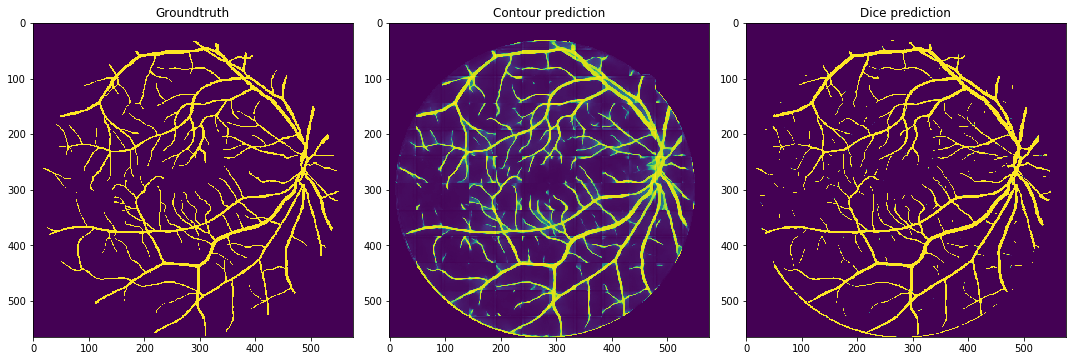

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
axes[0].imshow(masks[0])
axes[0].set_title('Groundtruth')

axes[1].imshow(contour_imgs[0])
axes[1].set_title('Contour prediction')

axes[2].imshow(dice_imgs[0])
axes[2].set_title('Dice prediction')

fig.tight_layout()
plt.show()

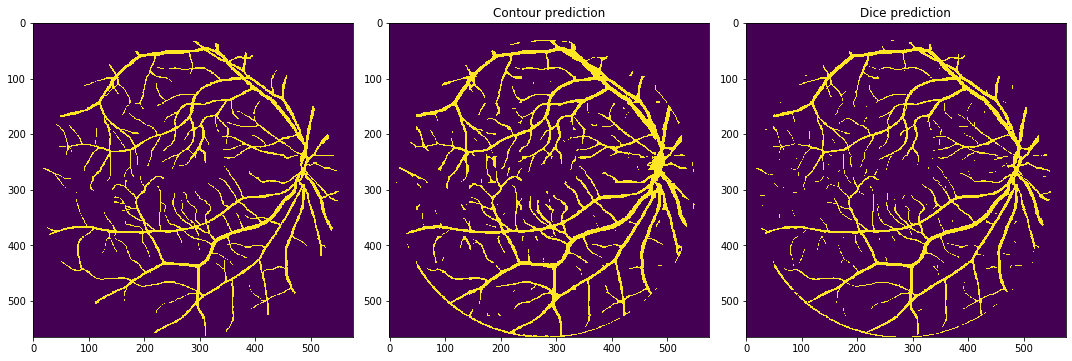

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
axes[0].imshow(masks[0])

axes[1].imshow(descrtetize(contour_imgs[0]))
axes[1].set_title('Contour prediction')

axes[2].imshow(descrtetize(dice_imgs[0]))
axes[2].set_title('Dice prediction')

fig.tight_layout()
plt.show()

In [46]:
contour_img_t = torch.from_numpy(contour_imgs[0]).unsqueeze(0).unsqueeze(0)
dice_img_t = torch.from_numpy(dice_imgs[0]).unsqueeze(0).unsqueeze(0)
bce_img_t = torch.from_numpy(bce_imgs[0]).unsqueeze(0).unsqueeze(0)
mask_t = torch.from_numpy(masks[0]).unsqueeze(0).unsqueeze(0)

In [125]:
def delta_dirac(x, eps=1, pi=np.pi):
    return eps / (pi * (eps**2 + x.pow(2)))


# def get_length(phi):
#     conv_filter_x = torch.tensor([[[[-1, 0, 1],
#                                     [-2, 0, 2],
#                                     [-1, 0, 1]]]], dtype=torch.double)
#     conv_filter_y = torch.tensor([[[[-1, -2, -1],
#                                     [0, 0, 0],
#                                     [1, 2, 1]]]], dtype=torch.double)
#     grad_x = F.conv2d(phi, conv_filter_x, padding=1)
#     grad_y = F.conv2d(phi, conv_filter_y, padding=1)

#     grad = (grad_x.pow(2) + grad_y.pow(2) + 1e-5).sqrt()
#     dd = delta_dirac(phi)
#     return torch.mul(grad, dd).mean(-1).mean(-1), grad

def get_length(phi):
    x = phi[:,:,1:,:] - phi[:,:,:-1,:] 
    y = phi[:,:,:,1:] - phi[:,:,:,:-1]
    
    delta_x = x[:,:,1:,:-2]**2
    delta_y = y[:,:,:-2,1:]**2
    delta_u = delta_x + delta_y
    
    return torch.sqrt(delta_u).mean(-1).mean(-1)

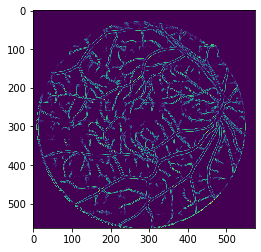

In [120]:
x = get_length(contour_img_t)
plt.imshow(x.squeeze(0).squeeze(0))
plt.show()

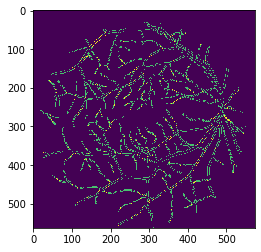

In [122]:
x = get_length(mask_t)
plt.imshow(x.squeeze(0).squeeze(0))
plt.show()

In [126]:
get_length(contour_img_t)

tensor([[0.0780]], dtype=torch.float64)

In [127]:
get_length(dice_img_t)

tensor([[0.0701]], dtype=torch.float64)

In [128]:
get_length(bce_img_t)

tensor([[0.0693]], dtype=torch.float64)

In [129]:
get_length(mask_t)

tensor([[0.0696]], dtype=torch.float64)

In [91]:
v, grad_contour = get_length(contour_img_t)
print(v)

tensor([[0.1232]], dtype=torch.float64)


In [92]:
v, grad_dice = get_length(dice_img_t)
print(v)

tensor([[0.1024]], dtype=torch.float64)


In [93]:
v, grad_bce = get_length(bce_img_t)
print(v)

tensor([[0.1065]], dtype=torch.float64)


In [94]:
v, grad = get_length(mask_t)
print(v)

tensor([[0.1058]], dtype=torch.float64)


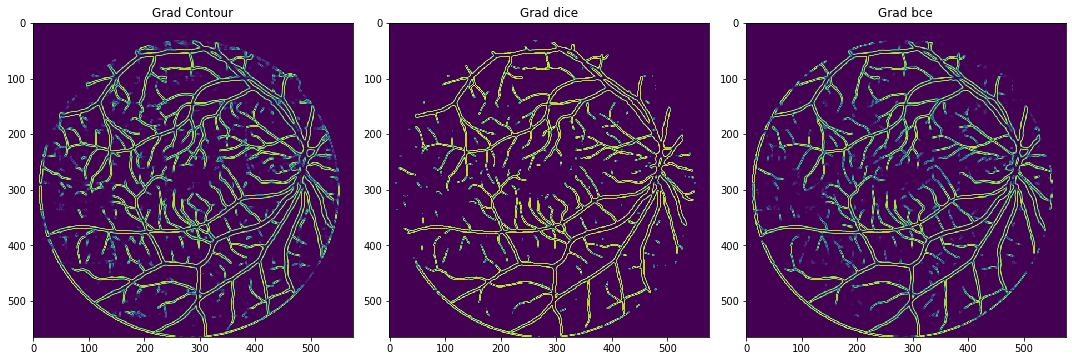

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))

axes[0].imshow(grad_contour.squeeze(0).squeeze(0).numpy())
axes[0].set_title('Grad Contour')

axes[1].imshow(grad_dice.squeeze(0).squeeze(0).numpy())
axes[1].set_title('Grad dice')

axes[2].imshow(grad_bce.squeeze(0).squeeze(0).numpy())
axes[2].set_title('Grad bce')

fig.tight_layout()
plt.show()